<a href="https://colab.research.google.com/github/zeeshansalim1234/Active-Learning-Summer-2023/blob/main/AL_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Install Transformers

In [ ]:
!pip install transformers

Loading Dataset

In [ ]:
# Open the text file in write mode
log_file = open('log.txt', 'w')

# Print and log messages
log_file.write('This is a log file.\n')


20

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/Processed_Solr_concatenated_posNeg.csv", delimiter=',', header=None, names=['index', 'index1', 'dependency', 'id1', 'id2', 'summary1', 'summary2', 'label'])

# Remove the first row from the DataFrame
df = df.drop(0)  # Pass the row index you want to drop as the argument to 'drop()'
df['label'] = df['label'].astype(int)
df = df.drop(['index', 'index1'], axis=1)

# Reset the index after removing the row
df = df.reset_index(drop=True)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 51,917



,dependency,id1,id2,summary1,summary2,label
2536,independent,13139877,12953680,replica skip recovery startup,add feature minisolrcloudcluster make shard/le...,1
23140,independent,13138659,12548521,rebalanceleaders api require preferredleader p...,update ant run example jvm debugging command l...,1
12051,independent,13139523,12541668,add back dynamic field single valued text field,disable random sampling langdetectlanguageiden...,1
37082,independent,13138275,12545530,solrcore lock non final member variable add fi...,make response writer available cross core with...,1
10680,independent,13139523,13031133,add back dynamic field single valued text field,use better check validate node recovered via p...,1
25422,independent,13138644,12699410,expose slow query api,support multiple wildcard highlight field,1
29626,independent,13138636,12374899,add default replication factor cluster property,make admin area search work without javascript,1
34007,independent,13138436,12638598,add support preferreplicatypes parameter,spatial distance document transformer,1
48609,independent,13137778,12458503,deprecate maxshardspernode creating collection,support arabic pdf extraction,1
38356,independent,13138036,13077982,create solr appender,updaterequestprocessorchains able use named urps,1


In [ ]:
label_distribution = df['label'].value_counts()
print(label_distribution)

1    50001
2     1650
0      266
Name: label, dtype: int64


In [ ]:
# Remove all label 0 entries
df = df[df['label'] != 0]

# make (`1` as `0`) and (`2` as `1`)
df.loc[df['label'] == 1, 'label'] = 0
df.loc[df['label'] == 2, 'label'] = 1

label_distribution = df['label'].value_counts()
print(label_distribution)

0    50001
1     1650
Name: label, dtype: int64


In [ ]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Undersample the majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,  # Set to False for undersampling
                                    n_samples=len(df_minority),  # Match minority class size
                                    random_state=42)

# Combine the undersampled majority class with the minority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the resulting DataFrame
df_undersampled = df_undersampled.sample(frac=1, random_state=42)

# Update the original DataFrame with the undersampled data
df = df_undersampled.copy()

# Reset the index after updating the DataFrame
df = df.reset_index(drop=True)

In [ ]:
label_distribution = df['label'].value_counts()
print(label_distribution)

0    1650
1    1650
Name: label, dtype: int64


In [ ]:
import random

# Add a new column 'AnnotationStatus' and initialize it with blank strings
df['AnnotationStatus'] = ''

# Set the seed value (to replicate)
seed_value = 31
random.seed(seed_value)

# Get a random sample of 300 row indices
random_rows = random.sample(range(df.shape[0]), 300)

# Set the 'AnnotationStatus' column to 'M' for the selected random rows
df.loc[random_rows, 'AnnotationStatus'] = 'M'

# Remove unnecessary columns
df = df.loc[:, ['summary1', 'summary2', 'label', 'AnnotationStatus']]

In [ ]:
print("DataFrame size: ", df.shape)
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

DataFrame size:  (3300, 4)
Number of rows:  3300
Number of columns:  4


In [ ]:
# Select rows with labels 0 and 1
df_label_1 = df[df['label'] == 0].head(2)
df_label_2 = df[df['label'] == 1].head(2)

# Extract 'summary1' and 'summary2' columns
summary_label_1 = df_label_1[['summary1', 'summary2']]
summary_label_2 = df_label_2[['summary1', 'summary2']]

# Print the summaries for label 0
print("Summaries for label 0:\n")
for _, row in summary_label_1.iterrows():
    print("summary1: "+row['summary1'])
    print("summary2: "+row['summary2'])
    print()

# Print the summaries for label 1
print("Summaries for label 1:\n")
for _, row in summary_label_2.iterrows():
    print("summary1: "+row['summary1'])
    print("summary2: "+row['summary2'])
    print()

Summaries for label 0:

summary1: better error handling parallel sql query
summary2: bin/solr script support option set dsolr solr home property

summary1: add support preferreplicatypes parameter
summary2: flexible ltr model us dsl describing scoring function

Summaries for label 1:

summary1: add gathernodes streaming expression support breadth first traversal
summary2: add sort streaming expression

summary1: solr admin ui create core named config set
summary2: allow core specify named config set non solrcloud mode



In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def tokenize_input(summary1, summary2, tokenizer):
  input_ids = []
  token_type_ids = []
  attention_masks = []

  MAX_LEN = 64

  # For every sentence...
  for i in range(len(summary1)):
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.

      #combined_summary = str(summary1[i])+"[SEP]"+str(summary2[i])

      encoded_sent = tokenizer.encode_plus(
                          str(summary1[i]),                      # Sentence to encode.
                          str(summary2[i]),                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          return_token_type_ids=True, # Return token_type_ids
                          max_length = MAX_LEN,
                          padding='max_length',

                          # This function also supports truncation and conversion
                          # to pytorch tensors, but we need to do padding, so we
                          # can't use these features :( .
                          #max_length = 128,          # Truncate all sentences.
                          #return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent["input_ids"])
      token_type_ids.append(encoded_sent["token_type_ids"])
      attention_masks.append(encoded_sent["attention_mask"])

  return input_ids, token_type_ids, attention_masks

In [ ]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print("\nNum Correct Predictions: ", str(np.sum(pred_flat == labels_flat)))
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def train(epochs, model, train_dataloader, validation_dataloader, scheduler, optimizer):

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # Store the average loss after each epoch so we can plot them.
  train_loss_values = []
  validation_loss_values = []
  accuracies = []

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      log_file.write('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      log_file.write('\nTraining...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_loss = 0
      total_validation_loss=0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          b_token_type_ids = batch[3].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # This will return the loss (rather than the model output) because we
          # have provided the `labels`.
          # The documentation for this `model` function is here:
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids,
                      token_type_ids=b_token_type_ids,  # Confirm this part with Gouri
                      attention_mask=b_input_mask,
                      labels=b_labels)

          # The call to `model` always returns a tuple, so we need to pull the
          # loss value out of the tuple.
          loss = outputs[0]

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over the training data.
      avg_train_loss = total_loss / len(train_dataloader)

      # Store the loss value for plotting the learning curve.
      train_loss_values.append(avg_train_loss)

      print("")
      log_file.write("\n  Average training loss: {0:.4f}".format(avg_train_loss))
      log_file.write("\n  Training epoch took: {:}".format(format_time(time.time() - t0)))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")
      log_file.write('\nRunning Validation...')

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)

          # Unpack the inputs from our dataloader
          b_input_ids, b_input_mask, b_labels, b_token_type_ids = batch

          # Telling the model not to compute or store gradients, saving memory and
          # speeding up validation
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # This will return the logits rather than the loss because we have
              # not provided labels.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here:
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              outputs = model(b_input_ids,
                              token_type_ids=b_token_type_ids,
                              attention_mask=b_input_mask)

          # Get the "logits" output by the model. The "logits" are the output
          # values prior to applying an activation function like the softmax.
          logits = outputs.logits  # Updated to use 'logits' from the outputs
          # Applying softmax along the second dimension (classes)
          probabilities = F.softmax(logits, dim=1)

          #print("probabilities :",probabilities)

          # Convert target_labels to one-hot encoding
          num_classes = 2
          target_labels_one_hot = torch.zeros(b_labels.size(0), num_classes).to(device)  # Move tensor to the same device as logits
          target_labels_one_hot.scatter_(1, b_labels.view(-1, 1), 1)

          #print("target_labels_one_hot: ", target_labels_one_hot)

          # Print the shapes of logits and target_labels_one_hot
          print("logits:", logits.shape)
          print("labels:", target_labels_one_hot.shape)

          # Compute the validation loss
          criterion = torch.nn.BCEWithLogitsLoss()
          validation_loss = criterion(logits, target_labels_one_hot.float())
          print("Validation loss:", validation_loss.item())

          total_validation_loss+=validation_loss

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences.
          print("\n\n")
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)

          # Accumulate the total accuracy.
          eval_accuracy += tmp_eval_accuracy

          # Track the number of batches
          nb_eval_steps += 1


      accuracy = eval_accuracy/nb_eval_steps
      accuracies.append(accuracy)

      avg_validation_loss = total_validation_loss/len(validation_dataloader)
      validation_loss_values.append(avg_validation_loss)

      # Report the final accuracy for this validation run.
      print("  Accuracy: {0:.4f}".format(accuracy))
      print("  Average validation loss: {0:.4f}".format(avg_validation_loss))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

      # Write to Log file
      log_file.write("\n  Average validation loss: {0:.4f}".format(avg_validation_loss))
      log_file.write("\n  Validation took: {:}".format(format_time(time.time() - t0)))
      log_file.write("\n  Accuracy: {0:.4f}".format(accuracy))


  print("")
  print("Training complete!")
  max_accuracy = max(accuracies)*100
  log_file.write("\n======================================")
  log_file.write("\nMax Accuracy: {:.4}%".format(max_accuracy))

  return train_loss_values, max_accuracy, validation_loss_values

In [ ]:
def setup_model(epochs):
  # Load BertForSequenceClassification, the pretrained BERT model with a single
  # linear classification layer on top.
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  return model, optimizer, scheduler

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def leastConfidenceSampling(df_uncertain):

    print("\n\nleastConfidenceSampling\n\n")
    df_uncertain['lconf']=1-df_uncertain['maxProb']
    df_uncertain = df_uncertain.sort_values(by=['lconf'],ascending=False)
    #logs.writeLog("\n\nLeast Confidence Calculations..."+str(len(df_uncertain))+" Rows\n"+str(df_uncertain[:10]))
    #logs.writeLog(str(df.index.values[0]))
    sampleIndex = df_uncertain.index.values[0]
    return sampleIndex

def minMarginSampling(df_uncertain):

    print("\n\minMarginSampling\n\n")
    df_uncertain['sorted'] = df_uncertain['predictedProb'].sort_values().apply(lambda x:sorted(x,reverse=True))
    df_uncertain['first'] = [x[0] for x in df_uncertain['sorted']]
    df_uncertain['second'] = [x[1] for x in df_uncertain['sorted']]
    df_uncertain['Margin'] = df_uncertain['first']-df_uncertain['second']

    df_uncertain = df_uncertain.sort_values(by=['Margin'],ascending=True)
    print("\n\nMin Margin Calcuations..."+str(len(df_uncertain))+" Rows\n"+str(df_uncertain[:10]))
    #logs.writeLog(str(df.index.values[0]))
    sampleIndex = df_uncertain.index.values[0]
    return sampleIndex

def entropySampling(df_uncertain):
    print("\n\entropySampling\n\n")
    df_uncertain['entropy'] = [entropy(x) for x in df_uncertain['predictedProb']]
    df_uncertain = df_uncertain.sort_values(by=['entropy'],ascending=False)
    #logs.writeLog("\n\nEntropy Calculations..."+str(len(df_uncertain))+" Rows\n"+str(df_uncertain[:10]))
    #logs.writeLog(str(df.index.values[0]))
    sampleIndex = df_uncertain.index.values[0]
    return sampleIndex


In [ ]:
import copy

fields = ['summary1','summary2','dependency','id1', 'id2','label']
label = 'label'
req1 = 'summary1'
req2 = 'summary2'
annStatus = 'AnnotationStatus'
maxProb = 'maxProb'
SAMPLING_TYPE = 'leastConfidence'
MANUAL_ANNOTATION_COUNT = 30

def analyzePredictions(df_predictions_input):
    '''
    Analyzis the predictions, samples the most uncertain data points and queries it from the oracle (original database/file) and updates dataframe accordingly.
    '''

    df_predictions = copy.deepcopy(df_predictions_input)

    """Intelligently Annotate"""

    # # Filter rows based on the condition
    # df_confident_predictions = df_predictions[df_predictions['maxProb'] >= THRESHOLD]

    # # Get the index values of the filtered rows
    # confident_indexes = df_confident_predictions.index

    # # Remove the filtered rows from df_predictions
    # df_predictions.drop(index=confident_indexes, inplace=True)
    # df_predictions.reset_index(drop=True, inplace=True)
    # df_confident_predictions['AnnotationStatus'] = 'I'  # Mark all rows as intelligently annotated
    # df_confident_predictions = df_confident_predictions[[req1,req2,label,annStatus, maxProb]]


    """Annotate with Active Learning (Manual)"""

    queryType = SAMPLING_TYPE
    df_userAnnot = pd.DataFrame(columns = fields)

    for field in [0,1]: # since there are only 2 labels
        iteration = 0
        #logs.writeLog("\n\nIteration for field: "+str(field))
        #input("hit enter to proceed")

        # This selects `manualAnnotationsCount` uncertain sample for each label, so total = manualAnnotationsCount * len(fields)
        while iteration<int(MANUAL_ANNOTATION_COUNT):  #while iteration is less than number of annotations that need to be done.
            if (len(df_predictions[df_predictions[label]==field ])>0):
                #logs.writeLog("\n\nIteration : "+str(iteration+1))
                if queryType == 'leastConfidence':
                    indexValue = leastConfidenceSampling(df_predictions[df_predictions[label]==field ])
                elif queryType == 'minMargin':
                    indexValue = minMarginSampling(df_predictions[df_predictions[label]==field ])
                elif queryType == 'entropy':
                    indexValue =entropySampling(df_predictions[df_predictions[label]==field ])

                # indexValue is the id of the row with the most uncertain sample

                sample = df_predictions.loc[indexValue,:]  # gets the row with the most uncertain sample
                #logs.writeLog("\n\nMost Uncertain Sample : \n"+str(sample))

                df_userAnnot = pd.concat([df_userAnnot, pd.DataFrame({req1: sample[req1], req2: sample[req2], label: sample[label], annStatus: 'M', maxProb: sample[maxProb]}, index=[0])], ignore_index=True)

                ##logs.createAnnotationsFile(df_userAnnot)

                #Remove the selected sample from the original dataframe
                df_predictions.drop(index=indexValue,inplace=True)
                df_predictions.reset_index(inplace=True,drop=True)
            else:
                print("All of unlabelled data is over")

                #df_manuallyAnnotated = pd.concat([df_manuallyAnnotated,df_userAnnot])

            iteration+=1

    # Instead of Stopping and Manually annotating, for the sake of efficiency of research, all labels are already Manullay annotated in dataset
    df_predictions=df_predictions[[req1,req2,label,annStatus]]#df_predictions[['comboId','req1Id','req1',req1,'req2Id','req2',req2,label,annStatus]]
    df_remaining = df_predictions
    df_remaining[annStatus] = ''
    #df_manuallyAnnotated=df_manuallyAnnotated[['comboId','req1Id','req1',req1,'req2Id','req2',req2,label,annStatus]]
    #logs.writeLog("\n\nManually Annotated Combinations... "+str(len(df_predictions))+"Rows \n"+str(df_predictions[:10]))

    df_userAnnot = df_userAnnot[[req1,req2,label,annStatus]]
    return df_userAnnot, df_remaining

In [ ]:
def active_learning(df_testing, predictions_list):
  # Create an empty DataFrame
  df_predictions_input = pd.DataFrame(columns=['summary1', 'summary2', 'label', 'AnnotationStatus', 'predictedProb', 'maxProb'])

  # Assign values to each column
  df_predictions_input['summary1'] = df_testing['summary1']
  df_predictions_input['summary2'] = df_testing['summary2']
  df_predictions_input['label'] = df_testing['label']
  df_predictions_input['AnnotationStatus'] = ''
  df_predictions_input['predictedProb'] = predictions_list
  df_predictions_input['maxProb'] = np.max(df_predictions_input['predictedProb'].tolist(), axis=1)

  return analyzePredictions(df_predictions_input)

In [ ]:
def predict_test_set(prediction_dataloader, model):
  # Set the batch size.
  batch_size = 32

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_type_ids = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(logits, dim=1)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    probabilities = probabilities.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(probabilities)
    true_labels.append(label_ids)

  print('    DONE.')

  flat_predictions = [item for sublist in predictions for item in sublist]

  predictions_list = [] # Probablities for all labels for the row
  for arr in flat_predictions:
    predictions_list.append(arr.tolist())

  flat_predictions_labels = np.argmax(flat_predictions, axis=1).flatten() # The predicted Label

  flat_true_labels = [item for sublist in true_labels for item in sublist] # Actual Labels

  print("Number of Predictions made: "+str(len(flat_predictions_labels)))
  print("Predictions Label: "+str(flat_predictions_labels[:30]))
  print("Actual Label: "+str(flat_true_labels[:30]))
  print("Prediction Probablities: "+str(predictions_list))

  correct_predictions = np.sum(flat_predictions_labels == flat_true_labels)
  total_predictions = len(flat_predictions_labels)
  accuracy = correct_predictions / total_predictions * 100

  return predictions_list

In [ ]:
def visualize_accuracy(accuracies):
    # Set up the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(accuracies) + 1), accuracies, 'b-o')

    # Label the plot
    plt.title("Training Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    # Display the plot
    plt.show()

In [ ]:
def split_and_tokenize_data(df_training, df_validation, df_testing):

  # For df_training
  train_summary1 = df_training.summary1.values
  train_summary2 = df_training.summary2.values
  train_labels = df_training.label.values
  train_labels = train_labels.astype(int)

  # For df_testing
  test_summary1 = df_testing.summary1.values
  test_summary2 = df_testing.summary2.values
  test_labels = df_testing.label.values
  test_labels = test_labels.astype(int)

  # For df_validation
  validation_summary1 = df_validation.summary1.values
  validation_summary2 = df_validation.summary2.values
  validation_labels = df_validation.label.values
  validation_labels = validation_labels.astype(int)

  # Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  # Get tokenized inputs
  train_inputs, train_token_type_ids, train_masks = tokenize_input(train_summary1, train_summary2, tokenizer)
  test_inputs, test_token_type_ids, test_masks = tokenize_input(test_summary1, test_summary2, tokenizer)
  validation_inputs, validation_token_type_ids, validation_masks = tokenize_input(validation_summary1, validation_summary2, tokenizer)


  # Convert all inputs and labels into torch tensors, the required datatype
  # for our model.
  train_inputs = torch.tensor(train_inputs)
  validation_inputs = torch.tensor(validation_inputs)
  test_inputs = torch.tensor(test_inputs)

  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(validation_labels)
  test_labels = torch.tensor(test_labels)

  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)
  test_masks = torch.tensor(test_masks)

  train_token_type_ids = torch.tensor(train_token_type_ids)
  validation_token_type_ids = torch.tensor(validation_token_type_ids)
  test_token_type_ids = torch.tensor(test_token_type_ids)

  # The DataLoader needs to know our batch size for training, so we specify it
  # here.
  # For fine-tuning BERT on a specific task, the authors recommend a batch size of
  # 16 or 32.

  batch_size = 32

  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_type_ids)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set.
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_type_ids)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  # Create the DataLoader for our test set.
  prediction_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_type_ids)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return train_dataloader, validation_dataloader, prediction_dataloader

In [ ]:
# While loop for Active Learning
import numpy as np
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F

pd.options.mode.chained_assignment = None


# Splitting the data for validation set
df_remaining, df_validation = train_test_split(df[df['AnnotationStatus'] != 'M'], test_size=0.1, random_state=42)

# Remove df_validation rows from df
df = df[~df.index.isin(df_validation.index)]

# Reset the index of the updated DataFrame
df = df.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)

print("df shape:", df.shape)
print("df_validation shape:", df_validation.shape)


count = 0
remaining = 1
list_train_loss_values = []
list_validation_loss_values = []
list_accuracies = []

while count<12 and remaining!=0:

  count+=1
  print("\n\nThis is the iteration number: "+str(count))
  log_file.write("\n\nThis is the iteration number: "+str(count))

  # Split the DataFrame based on 'AnnotationStatus'
  # We split it into train and test
  # Train will be further split into train and validation
  df_training = df[df['AnnotationStatus'] == 'M']
  df_testing = df[df['AnnotationStatus'] != 'M']

  log_file.write("\n\nSize of df_training: "+str(df_training.shape))
  log_file.write("\nSize of df_testing: "+str(df_testing.shape))

  "Spit and Tokenize data and recieve Data Loaders"
  train_dataloader, validation_dataloader, prediction_dataloader = split_and_tokenize_data(df_training, df_validation, df_testing)

  "Setup Model"

  # Number of training epochs (authors recommend between 2 and 4)
  epochs = 6
  model, optimizer, scheduler = setup_model(epochs)

  "Run Training (Fine-Tune)"

  train_loss_values, accuracy, validation_loss_values = train(epochs, model, train_dataloader, validation_dataloader, scheduler, optimizer) # Fine-Tune the model

  list_train_loss_values.append(train_loss_values)
  list_validation_loss_values.append(validation_loss_values)
  list_accuracies.append(accuracy)

  "Evaluate Test Results"

  print('Predicting labels for {:,} test sentences...'.format(len(df_testing.index)))

  predictions_list = predict_test_set(prediction_dataloader, model)  # make predictions on test set

  df_annotated, df_remaining = active_learning(df_testing, predictions_list)

  "Update the original df"

  # Concatenate the DataFrames
  df = pd.concat([df_training, df_annotated, df_remaining])

  # Reset the index of the concatenated DataFrame
  df = df.reset_index(drop=True)

  # Count the occurrences of 'M' in the 'AnnotationStatus' column
  count_m = df['AnnotationStatus'].value_counts()['M']
  remaining = 3300-count_m

  # Print the count
  print("Number of rows with 'AnnotationStatus' set to 'M':", count_m)


df shape: (3000, 4)
df_validation shape: (300, 4)


This is the iteration number: 1
Loading BERT tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6270099878311157




Num Correct Predictions:  24
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6023107171058655




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6003178358078003




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5853379964828491




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5871548056602478




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5977097749710083




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5822453498840332




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6761461496353149




Num Correct Predictions:  17
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6997125148773193




Num Correct Predictions:  15
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6772466897964478




Num Correct Predictions:  19
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6809980869293213




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.7107598185539246




Num Correct Predictions:  13
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6909818649291992




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6595478057861328




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6708825826644897




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6948875188827515




Num Correct Predictions:  16
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6768423318862915




Num Correct Predictions:  17
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6870101690292358




Num Correct Predictions:  17
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6908023357391357




Num Correct Predictions:  14
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6832030415534973




Num Correct Predictions:  16
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6601769924163818




Num Correct Predictions:  22
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6779928207397461




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6867982745170593




Num Correct Predictions:  16
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6775628328323364




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6778773069381714




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6927465796470642




Num Correct Predictions:  13
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6815637350082397




Num Correct Predictions:  18
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6668892502784729




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6661607027053833




Num Correct Predictions:  24
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6723825335502625




Num Correct Predictions:  20
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6618545055389404




Num Correct Predictions:  24
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6583291888237




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6713398098945618




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6717996001243591




Num Correct Predictions:  22
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6567420959472656




Num Correct Predictions:  28
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Valid

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6402651071548462




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6493484973907471




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6390025019645691




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6355537176132202




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.648510217666626




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6478347778320312




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6213007569313049




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6683052778244019




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6731460094451904




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6725184917449951




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6656745672225952




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6713500618934631




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6708008050918579




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6578657031059265




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6281030178070068




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6452406644821167




Num Correct Predictions:  25
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6344019770622253




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6256990432739258




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6457520723342896




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6499814987182617




Num Correct Predictions:  26
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6168675422668457




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6250020265579224




Num Correct Predictions:  28
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6369704604148865




Num Correct Predictions:  27
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6262741088867188




Num Correct Predictions:  29
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6203006505966187




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6298291683197021




Num Correct Predictions:  28
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6448259353637695




Num Correct Predictions:  25
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6167773008346558




Num Correct Predictions:  28
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6343483924865723




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6453917622566223




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6393029689788818




Num Correct Predictions:  22
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6309980154037476




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6258907318115234




Num Correct Predictions:  24
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6522936820983887




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6366864442825317




Num Correct Predictions:  22
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5953339338302612




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6079070568084717




Num Correct Predictions:  28
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5861456394195557




Num Correct Predictions:  31
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5821086168289185




Num Correct Predictions:  31
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6089605689048767




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6061298847198486




Num Correct Predictions:  30
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.5736391544342041




Num Correct Predictions:  31
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Va

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
Training...


Running Validation...
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6280192136764526




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6632403135299683




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6357159614562988




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6390300989151001




Num Correct Predictions:  23
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.654225766658783




Num Correct Predictions:  20
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6445218324661255




Num Correct Predictions:  21
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Validation loss: 0.6218620538711548




Num Correct Predictions:  24
logits: torch.Size([32, 2])
labels: torch.Size([32, 2])
Val

In [ ]:

# Print the count
print("Number of rows with 'AnnotationStatus' set to 'M':", count_m)

# Close the text file
log_file.close()

# Convert the list of tensors to a single tensor with an additional dimension
stacked_tensor = torch.stack([torch.stack(sublist) for sublist in list_validation_loss_values])

Number of rows with 'AnnotationStatus' set to 'M': 1020


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_training(loss_values_list, loss_type):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15, 8)  # Increase the figure size

    # Define a custom color palette with more distinct colors
    num_plots = len(loss_values_list)
    color_palette = sns.color_palette("tab10", num_plots)

    # Plot the learning curves for each set of loss values.
    for i, loss_values in enumerate(loss_values_list):
        plt.plot(loss_values, label=f"Iter {i+1}", color=color_palette[i])

    # Label the plot.
    plt.title(loss_type)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Set y-axis limits from 0.0 to 0.8
    plt.ylim(0.0, 0.8)

    # Move the legend below the x-axis and reduce the number of columns in the legend
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, frameon=False)

    # Adjust the figure size to match the x-axis length
    ax = plt.gca()
    ax.set_aspect(1.0 / ax.get_data_ratio())

    # Increase the bottom margin for the legend
    plt.subplots_adjust(bottom=0.2)

    plt.show()


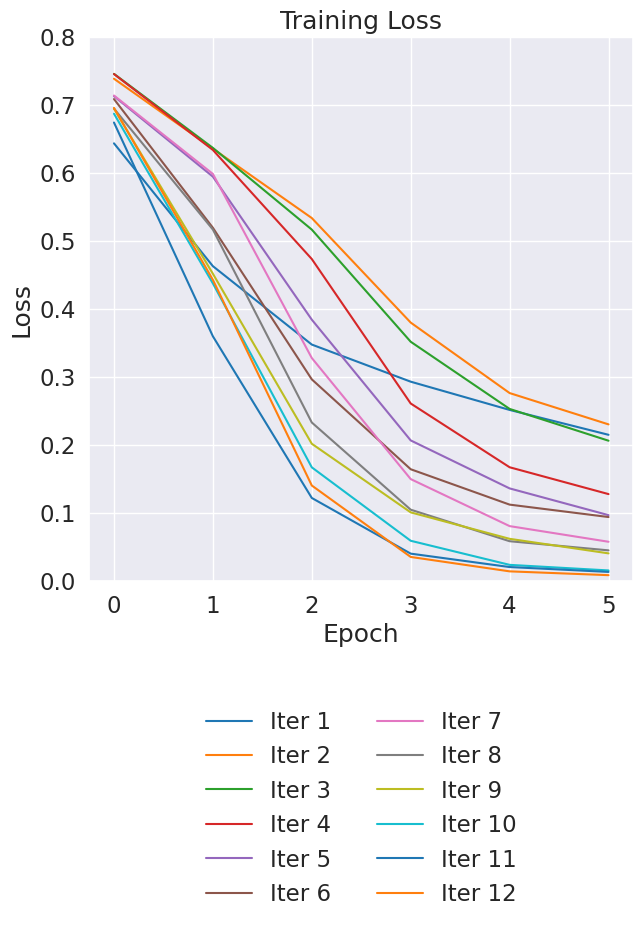

In [ ]:
visualize_training(list_train_loss_values, "Training Loss")

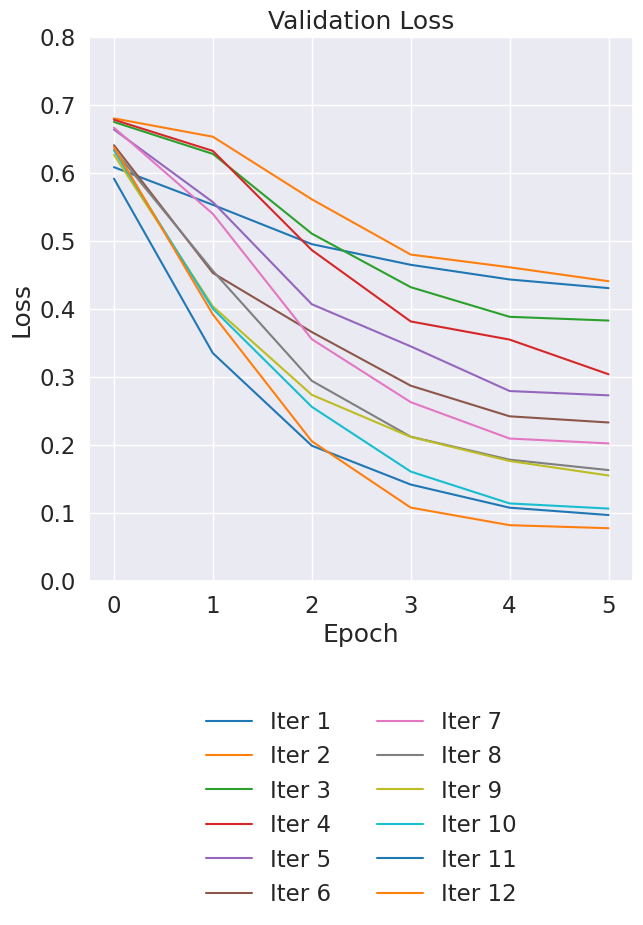

In [ ]:

# Convert the stacked tensor to a NumPy array
list_validation_loss_values = stacked_tensor.cpu().numpy()
visualize_training(list_validation_loss_values, "Validation Loss")

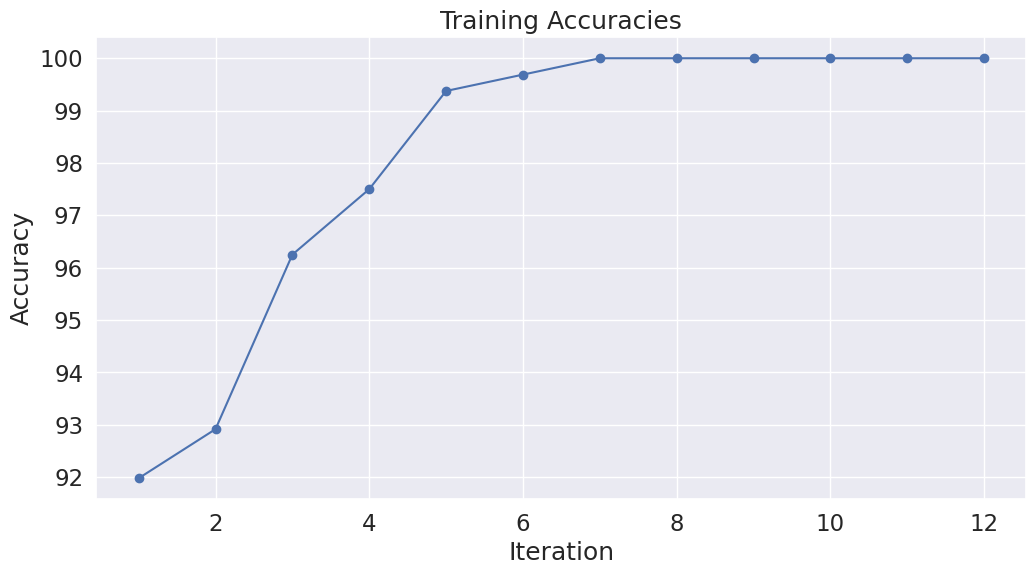

In [ ]:
visualize_accuracy(list_accuracies)

In [ ]:
merged_df = pd.merge(df_validation, df, how='inner')

if merged_df.empty:
    print("No common rows between df_validation and df")
else:
    print("Common rows found between df_validation and df")
    print(merged_df)

Common rows found between df_validation and df
                                            summary1  \
0                umbrella ticket streaming sql issue   
1  allow least solrconfig xml schema xml edited v...   

                                            summary2 label AnnotationStatus  
0  add complementstream streaming api streaming e...     1                   
1       allow submit config schema creating new core     1                   


In [ ]:
print(SAMPLING_TYPE)

leastConfidence
